<a href="https://colab.research.google.com/github/Supriya090/Knowledge-Graph-Task/blob/master/KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing with Pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#reading the generated csv file
news_info = pd.read_csv('/content/news_data.csv')
news_info.head()

,TITLE,CONTENT
0,\nGovt collects Rs 92.78 billion in fuel taxes...,"\nKathmandu, May 24\nAs the fuel prices keep o..."
1,\n2nd fuel price hike in 8 days: Petrol Rs 180...,"\nKathmandu, May 23\nThe government-run fuel d..."
2,\nGovt reducing airport infrastructure budget ...,"\nKathmandu, May 22\nThe governing is reducing..."
3,\nNepal imported gold worth Rs 35.77 billion i...,"\nKathmandu, May 22\nWhile there are reports t..."
4,\nFood delivery services are booming in Kathma...,"\nA couple of weeks back, Bintika Kafle of Kat..."


In [3]:
#replacing the newline as blank space
news_info = news_info.replace(r'\n',' ', regex=True) 
#changing content column to lowercase
news_info['CONTENT'] = news_info['CONTENT'].str.lower()
#removing commas from content column
news_info['CONTENT'] = news_info['CONTENT'].str.replace(',','')
news_info.head()

,TITLE,CONTENT
0,Govt collects Rs 92.78 billion in fuel taxes ...,kathmandu may 24 as the fuel prices keep on i...
1,"2nd fuel price hike in 8 days: Petrol Rs 180,...",kathmandu may 23 the government-run fuel dist...
2,Govt reducing airport infrastructure budget t...,kathmandu may 22 the governing is reducing it...
3,Nepal imported gold worth Rs 35.77 billion in...,kathmandu may 22 while there are reports that...
4,Food delivery services are booming in Kathman...,a couple of weeks back bintika kafle of kathm...


In [4]:
#removing the date and place of report
news_info["CONTENT"] = news_info["CONTENT"].str.split().str[3:].str.join(sep=" ")
print(news_info.head())

                                               TITLE  \
0   Govt collects Rs 92.78 billion in fuel taxes ...   
1   2nd fuel price hike in 8 days: Petrol Rs 180,...   
2   Govt reducing airport infrastructure budget t...   
3   Nepal imported gold worth Rs 35.77 billion in...   
4   Food delivery services are booming in Kathman...   

                                             CONTENT  
0  as the fuel prices keep on increasing you migh...  
1  the government-run fuel distribution monopoly ...  
2  the governing is reducing its airport infrastr...  
3  while there are reports that the country’s eco...  
4  weeks back bintika kafle of kathmandu was home...  


## Sentence Segmentation with spaCy

In [5]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

#Segmenting the news content into sentences and placing them in the same list
news = news_info["CONTENT"]
sentences = []
for each_news in news:
  indv_sentences = [i for i in nlp(each_news).sents]
  sentences.extend(indv_sentences)
print(sentences[0:5])

[as the fuel prices keep on increasing you might have already understood that one of the reasons is the high fuel taxes levied by the government., apparently the fuel prices are quite high as the government collected rs 92.78 billion in the past 10 months., following the recent fuel price hike on sunday the nepal oil corporation the government-run fuel distribution monopoly has to pay rs 63.23 in taxes to the government for a litre of petrol., likewise the corporation has to pay in taxes rs 45.91 for a litre of diesel and rs 13.66 for a litre of kerosene., meanwhile the new fuel tax rate for a cylinder of cooking gas is rs 327.27.]


The ideal case is one subject and one object but due to complex sentences in Online Khabar, it is diffult to obtain that.

---



In [6]:
# Checking the syntatic structure and parts of speech in the sentence
doc = nlp("apparently the fuel prices are quite high as the government collected rs 92.78 billion in the past 10 months")

for tok in doc:
  print(tok.text, "-->", tok.dep_, "-->", tok.pos_)

apparently --> advmod --> ADV
the --> det --> DET
fuel --> compound --> NOUN
prices --> nsubj --> NOUN
are --> ROOT --> AUX
quite --> advmod --> ADV
high --> acomp --> ADJ
as --> mark --> SCONJ
the --> det --> DET
government --> nsubj --> NOUN
collected --> advcl --> VERB
rs --> quantmod --> NOUN
92.78 --> compound --> NUM
billion --> dobj --> NUM
in --> prep --> ADP
the --> det --> DET
past --> amod --> ADJ
10 --> nummod --> NUM
months --> pobj --> NOUN


## Entity Pair Extraction

In [7]:
# getting the entities
def get_entities(entry):
  ent1 = ""
  ent2 = ""

  prev_tok_dep = ""     # dependency tag of previous token in the sentence
  prev_tok_text = ""    # previous token in the sentence

  # holds the text associated with the subject or the object
  prefix = ""
  modifier = ""


  for tok in nlp(entry):
    # if token is punctuation, move on to the next token
    if tok.dep_ != "punct":
      # checking if the token is a compound word
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a compound, then adding the current word to it
        if prev_tok_dep == "compound":
          prefix = prev_tok_text + " "+ tok.text

      # checking if the token is a modifier
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a compound, then adding the current word to it
        if prev_tok_dep == "compound":
          modifier = prev_tok_text + " "+ tok.text

      # capturing the token as first entity if it is a subject
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        # resetting the variables
        prefix = ""
        modifier = ""
        prev_tok_dep = ""
        prev_tok_text = ""

      # capturing the token as second entity if it is an object
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix + " "+ tok.text
        # resetting the variables
        prefix = ""
        modifier = ""
        prev_tok_dep = ""
        prev_tok_text = ""

      # updating previous tokens and dependencies
      prev_tok_dep = tok.dep_
      prev_tok_text = tok.text

  # returning the entities
  return [ent1.strip(), ent2.strip()]

In [8]:
# testing the get_entities function
get_entities("the decision comes into effect on wednesday")   #using a simple sentence for better functionality

['decision', 'wednesday']

In [9]:
# type conversion
print(type(sentences[0]))
print(type(sentences[0].text))
get_entities(sentences[0].text)

<class 'spacy.tokens.span.Span'>
<class 'str'>


['already  one', 'high fuel government']

In [10]:
#Extracting entity pairs for all the sentences
entity_pairs = []

for each_sentence in sentences:
  entity_pairs.append(get_entities(each_sentence.text))

print(entity_pairs[0:5])

[['already  one', 'high fuel government'], ['quite  government', '10  months'], ['run fuel distribution monopoly', 'petrol'], ['likewise  corporation', 'kerosene'], ['new fuel tax rate', 'cooking  gas']]


## Relation/Predicate Extraction using spaCy's Rule-based Matching
Assuming relation/predicate as the main verb in the sentence

In [11]:
# getting relations from sentences
def get_relation(entry):

  # creating a spaCy object
  doc = nlp(entry)

  # creating a matcher class object 
  matcher = Matcher(nlp.vocab)

  # defining the pattern 
  pattern = [{'DEP':'ROOT'},            # finds root word in the sentence
            {'DEP':'prep','OP':"?"},    # checks if it is followed by preposition
            {'DEP':'agent','OP':"?"},   # checks if it is followed by agent
            {'POS':'ADJ','OP':"?"}]     # checks adjective part of speech 

  # adding rule to the matcher
  matcher.add("match_1", None, pattern)

  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 

  return (span.text)

In [12]:
# testing get_relation function
get_relation("the decision comes into effect on wednesday")

'comes into'

In [13]:
# getting relations from all the sentences
relations = []

for each_sentence in sentences:
  relations.append(get_relation(each_sentence.text))

print(relations[0:5])

['understood', 'are', 'has', 'has', 'is']


In [14]:
# looking at the most frequent relations
pd.Series(relations).value_counts()[:20]

says         29
is           14
was           5
states        3
say           3
said          3
are           3
been          3
takes         2
start         2
preparing     2
adds          2
made          2
given         2
stopped       2
ordered       2
wants         2
projected     2
is at         2
has           2
dtype: int64

## Building a Knowledge Graph with networkx

Creating a dataframe of entities and predicates

In [15]:
# extracting subject
source = [i[0] for i in entity_pairs]

# extracting object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'SOURCE':source, 'TARGET':target, 'EDGE':relations})

In [16]:

# creating a directed-graph from a dataframe
graph = nx.from_pandas_edgelist(kg_df, "SOURCE", "TARGET", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

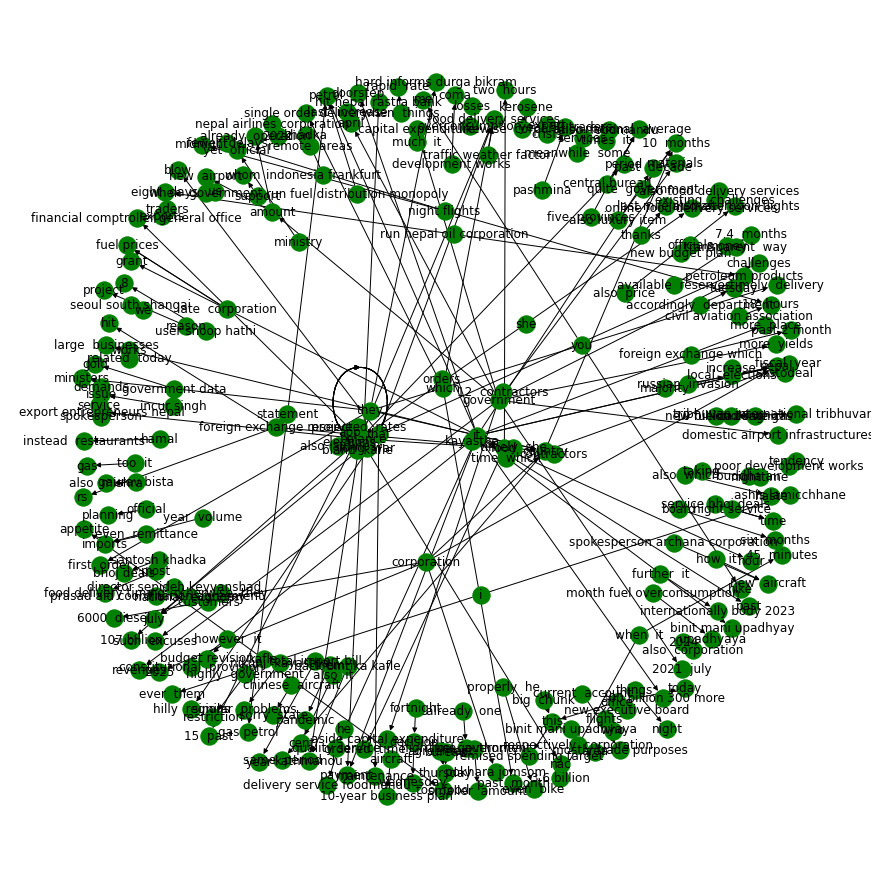

In [17]:
# plotting the network
plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='green', pos = pos)
plt.show()

We obtained knowledge graph for all the sentences above, we can also do it for a specific relation.

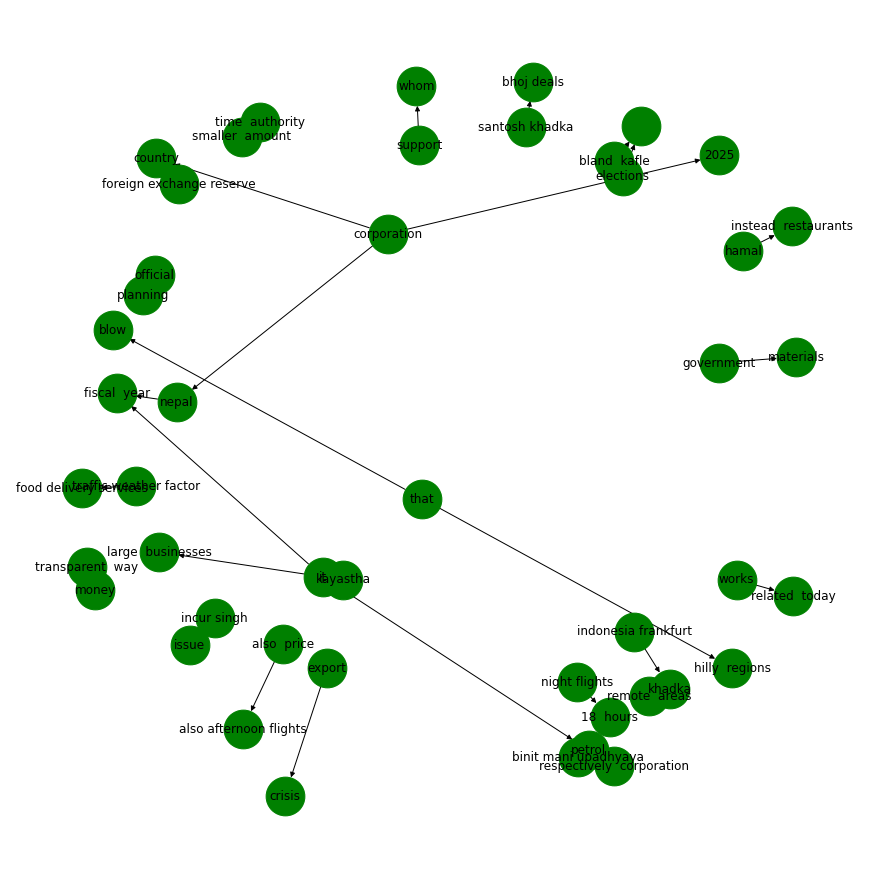

In [18]:
graph_1 = nx.from_pandas_edgelist(kg_df[kg_df['EDGE']=="says"], "SOURCE", "TARGET", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph_1)
nx.draw(graph_1, with_labels=True, node_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Saving the Graph

Integrating graph database(Neo4j) with networkx required interaction with third party APIs and outdated libraries, hence used the simpler option of saving the graph using python pickle

In [19]:
nx.write_gpickle(graph,'myGraph.gpickle')

## Answering Questions

In [20]:
# reading the graph from python pickle
news_kgraph = nx.read_gpickle('myGraph.gpickle')

In [ ]:
# checking the edges
news_kgraph.edges()

In [23]:
# importing ntlk for stemming
import nltk
from nltk.stem.porter import *

# preparing stemmer
stemmer = PorterStemmer()

In [24]:
# getting answer to questions
def get_answer(question):

  # getting the main verb from the question and stemming
  relation = get_relation(question)
  stemmed_relation = stemmer.stem(relation)
  # getting the subject from the question
  subject = get_entities(question)[0]

  # getting the edgelist from the graph considering the subject as the node
  df = nx.to_pandas_edgelist(news_kgraph, nodelist=[subject])
  for idx, row in df.iterrows():
    if ' ' not in df.loc[idx, "EDGE"]:
      df.loc[idx, "EDGE"] = stemmer.stem(df.loc[idx, "EDGE"])
  
  # print the target answer is the subject is not empty
  if subject != '':
    print(df.loc[df["EDGE"] == stemmed_relation].target.item())

In [25]:
# Question 1
get_answer("What did the government earn ?")

revenues


In [26]:
# Question 2
get_answer("What time do night flights start at ?")

midnight
